In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d

from numba import njit
from src.model_tech_dice import hjb_post_damage_post_tech, hjb_post_damage_pre_tech
from src.model_tech_dice import hjb_pre_damage_post_tech, hjb_pre_damage_pre_tech
from src.utilities import find_nearest_value
from src.simulation_2d import EvolutionState, simulation_dice_prob

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
##################
ξ_a = 2./100
ξ_p = 5.
arrival = 20
τ = 2.
y_bar_lower = 1.5
n_model = 20
##################

I_g_first = 1./arrival
I_g_second = 1./arrival
ξ_g_first = ξ_p
ξ_g_second = ξ_p
ξ_b = ξ_p

# Model parameters
δ = 0.01
α = 0.115
κ = 6.667
μ_k = -0.043
σ_k = np.sqrt(0.0087**2 + 0.0038**2)

theta = 3
lambda_bar = 0.1206
vartheta_bar = 0.0453

γ_1 = 1.7675/10000
γ_2 = .0022*2

γ_3_lower = 0.
γ_3_upper = 1./3

# Compute γ_3 for the n models
def Γ(y, y_bar, γ_1, γ_2, γ_3):
    return γ_1 * y + γ_2 / 2 * y ** 2 + γ_3 / 2 * (y > y_bar) * (y - y_bar) ** 2

prop_damage_lower = np.exp(-Γ(2.5, 2., γ_1, γ_2, γ_3_upper))
prop_damage_upper = np.exp(-Γ(2.5, 2., γ_1, γ_2, γ_3_lower))
γ_3 = (-np.log(np.linspace(prop_damage_lower, prop_damage_upper, n_model)) - γ_1 * 2.5 - γ_2 / 2 * 2.5**2) / .5**2 * 2
γ_3.sort()
γ_3[0] = 0
πd_o = np.ones(n_model)/n_model

θ = pd.read_csv('data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

# Grid setting
k_step = .1
k_grid = np.arange(0, 10+k_step, k_step)

y_step = .1
y_grid_long = np.arange(0., 5.+y_step, y_step)
y_grid_short = np.arange(0., 2.5+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, τ) + 1

# Tech jump
lambda_bar_first = lambda_bar / 2
vartheta_bar_first = vartheta_bar / 2
lambda_bar_second = 1e-9
vartheta_bar_second = 0.

In [3]:
# Solve post damage, post second tech jump models
model_post_damage_post_second_tech = []
for i, γ_3_i in enumerate(γ_3):
    model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, γ_1, γ_2, γ_3_i, τ, theta, lambda_bar_second, vartheta_bar_second)
    if i == 0:
        v_guess = None
    else:
        v_guess = model_res['v']
    model_res = hjb_post_damage_post_tech(k_grid, y_grid_long, model_args, v0=v_guess, ϵ=1., fraction=.05,
                                          tol=1e-6, max_iter=2000, print_iteration=False)
    model_post_damage_post_second_tech.append(model_res)

Converged. Total iteration 1636: LHS Error: 9.93537241811282e-07; RHS Error 9.61302791147034e-07
Converged. Total iteration 5: LHS Error: 9.93164348983555e-07; RHS Error 9.632327593322998e-07
Converged. Total iteration 3: LHS Error: 9.85425117505656e-07; RHS Error 9.564560432551161e-07
Converged. Total iteration 2: LHS Error: 9.790725243874476e-07; RHS Error 9.513476655342856e-07
Converged. Total iteration 1: LHS Error: 9.866284926829394e-07; RHS Error 9.592987728623825e-07
Converged. Total iteration 1: LHS Error: 9.768783684194204e-07; RHS Error 9.48565491043496e-07
Converged. Total iteration 1: LHS Error: 9.669053042671294e-07; RHS Error 9.388116204434027e-07
Converged. Total iteration 1: LHS Error: 9.567093002260663e-07; RHS Error 9.290674958251088e-07
Converged. Total iteration 1: LHS Error: 9.462909247304196e-07; RHS Error 9.19122395970362e-07
Converged. Total iteration 1: LHS Error: 9.368314977109549e-07; RHS Error 9.089777028847834e-07
Converged. Total iteration 1: LHS Error: 9.

In [4]:
# Solve post damage, post first tech jump models
model_post_damage_post_first_tech = []
for i, γ_3_i in enumerate(γ_3):
    model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, ξ_g_second, I_g_second,
                  model_post_damage_post_second_tech[i]['v'], γ_1, γ_2,
                  γ_3_i, τ, theta, lambda_bar_first, vartheta_bar_first)
    if i == 0:
        v_guess = model_res['v']
    else:
        v_guess = model_res['v']
    model_res = hjb_post_damage_pre_tech(k_grid, y_grid_long, model_args, v0=v_guess, ϵ=1., fraction=.05,
                                         tol=1e-6, max_iter=2000, print_iteration=False)
    model_post_damage_post_first_tech.append(model_res)

Converged. Total iteration 541: LHS Error: 9.842557346928515e-07; RHS Error 0.0010687328440752708
Converged. Total iteration 273: LHS Error: 9.648454124544514e-07; RHS Error 0.0016796313004867613
Converged. Total iteration 260: LHS Error: 9.214454621542245e-07; RHS Error 0.002271565426841704
Converged. Total iteration 204: LHS Error: 9.654537507230998e-07; RHS Error 0.002710083905128613
Converged. Total iteration 204: LHS Error: 9.647611705076997e-07; RHS Error 0.003060351821893903
Converged. Total iteration 204: LHS Error: 9.637055882194545e-07; RHS Error 0.003347383039510987
Converged. Total iteration 204: LHS Error: 9.626048722566338e-07; RHS Error 0.0035859665045840927
Converged. Total iteration 204: LHS Error: 9.767375104274834e-07; RHS Error 0.0037911093095317483
Converged. Total iteration 204: LHS Error: 9.77251374933985e-07; RHS Error 0.003973591909744556
Converged. Total iteration 204: LHS Error: 9.776529168448178e-07; RHS Error 0.004129053816026129
Converged. Total iteration 

In [5]:
# Solve post damage pre tech jump models
model_post_damage_pre_tech = []
for i, γ_3_i in enumerate(γ_3):
    model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, ξ_g_first, I_g_first,
                  model_post_damage_post_first_tech[i]['v'], γ_1, γ_2,
                  γ_3_i, τ, theta, lambda_bar, vartheta_bar)
    if i == 0:
        v_guess = model_res['v']
    else:
        v_guess = model_res['v']
    model_res = hjb_post_damage_pre_tech(k_grid, y_grid_long, model_args, v0=v_guess, ϵ=1., fraction=.05,
                                         tol=1e-6, max_iter=2000, print_iteration=False)
    model_post_damage_pre_tech.append(model_res)

Converged. Total iteration 1601: LHS Error: 9.99930875877908e-07; RHS Error 0.0022845041268801936
Converged. Total iteration 388: LHS Error: 9.96676021713938e-07; RHS Error 0.003520769342642893
Converged. Total iteration 2000: LHS Error: 2.0432402152437135e-06; RHS Error 0.0044641802719525
Converged. Total iteration 361: LHS Error: 9.992845662054606e-07; RHS Error 0.00518248108948427
Converged. Total iteration 301: LHS Error: 9.933030469255755e-07; RHS Error 0.005774318924792965
Converged. Total iteration 301: LHS Error: 9.9272051556909e-07; RHS Error 0.006273297286252699
Converged. Total iteration 301: LHS Error: 9.938891025740304e-07; RHS Error 0.0067020763507805725
Converged. Total iteration 301: LHS Error: 9.92791115095315e-07; RHS Error 0.0070880266089297095
Converged. Total iteration 301: LHS Error: 9.88793885881023e-07; RHS Error 0.0074330547668530755
Converged. Total iteration 301: LHS Error: 9.890088676911546e-07; RHS Error 0.007737020015625262
Converged. Total iteration 301: 

In [6]:
# Solve pre damage, post second tech models
v_i_short = []
for model in model_post_damage_post_second_tech:
    temp = np.zeros((len(k_grid), len(y_grid_short)))
    for i in range(temp.shape[1]):
        temp[:, i] = model['v'][:, n_bar-1]
    v_i_short.append(temp)
v_i_short = np.array(v_i_short)

model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, ξ_p, πd_o, v_i_short, γ_1, γ_2, theta, lambda_bar_second, vartheta_bar_second, y_bar_lower)
model_pre_damage_post_second_tech = hjb_pre_damage_post_tech(k_grid, y_grid_short, model_args=model_args, v0=np.mean(v_i_short, axis=0),
                                                             ϵ=1., fraction=.05, tol=1e-6, max_iter=2_000, print_iteration=True)

Iteration 1: LHS Error: 9.015579962579068e-07; RHS Error 8.740821009212141e-07
Converged. Total iteration 1: LHS Error: 9.015579962579068e-07; RHS Error 8.740821009212141e-07


In [7]:
# Solve pre damage, post first tech models
v_i_short = []
for model in model_post_damage_post_first_tech:
    temp = np.zeros((len(k_grid), len(y_grid_short)))
    for i in range(temp.shape[1]):
        temp[:, i] = model['v'][:, n_bar-1]
    v_i_short.append(temp)
v_i_short = np.array(v_i_short)

model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, ξ_g_second, ξ_p,
              πd_o, v_i_short, I_g_second, model_pre_damage_post_second_tech['v'], γ_1, γ_2,
              theta, lambda_bar_first, vartheta_bar_first, y_bar_lower)

model_pre_damage_post_first_tech = hjb_pre_damage_pre_tech(k_grid, y_grid_short, model_args=model_args, v0=np.mean(v_i_short, axis=0),
                                                           ϵ=.1, fraction=.05, tol=1e-6, max_iter=2_000, print_iteration=False)

Converged. Total iteration 1684: LHS Error: 0.0; RHS Error 0.0034613083021710622


In [8]:
# Solve pre damage, pre tech models
v_i_short = []
for model in model_post_damage_pre_tech:
    temp = np.zeros((len(k_grid), len(y_grid_short)))
    for i in range(temp.shape[1]):
        temp[:, i] = model['v'][:, n_bar-1]
    v_i_short.append(temp)
v_i_short = np.array(v_i_short)

model_args = (δ, α, κ, μ_k, σ_k, θ, πc_o, σ_y, ξ_a, ξ_b, ξ_g_first, ξ_p,
              πd_o, v_i_short, I_g_first, model_pre_damage_post_first_tech['v'], γ_1, γ_2,
              theta, lambda_bar, vartheta_bar, y_bar_lower)

model_pre_damage_pre_tech = hjb_pre_damage_pre_tech(k_grid, y_grid_short, model_args=model_args, v0=np.mean(v_i_short, axis=0),
                                                    ϵ=.1, fraction=.05, tol=1e-6, max_iter=2_000, print_iteration=False)

Converged. Total iteration 1863: LHS Error: 0.0; RHS Error 0.010778038278772328


## Simulation

In [9]:
# Case 1) : damage jump intensity & probability (no tech jump, no damage jump)
T_plots = 50
sim_args = (κ, μ_k, σ_k, np.mean(θ))
et, kt, yt, _, gt, πct, ht = simulation_dice_prob(sim_args, k_grid, y_grid_short,
                                      model_pre_damage_pre_tech['e'],
                                      model_pre_damage_pre_tech['i'],
                                      model_pre_damage_pre_tech['g'],
                                      model_pre_damage_pre_tech['h'],
                                      model_pre_damage_pre_tech['πc'],
                                      K0=85/0.115, y0=1.1, T=T_plots)

def damage_intensity(y, y_bar_lower):
    r1 = 1.5
    r2 = 2.5
    return r1 * (np.exp(r2/2 * (y - y_bar_lower)**2) - 1) * (y >= y_bar_lower)

intensity_dmg = damage_intensity(yt, y_bar_lower)
intensity_distortion = np.mean(gt, axis=0)
distorted_damage_probs = gt / np.mean(gt, axis=0) / n_model

In [10]:
np.save('new_intensity_dmg_5.npy', intensity_dmg)
np.save(f'new_dmg_intensity_distort_{ξ_p}.npy', intensity_distortion)

In [11]:
# Case 2) : tech jump intensity & probability (no tech jump, no damage jump)
T_plots = 50
sim_args = (κ, μ_k, σ_k, np.mean(θ))
_, kt, yt, _, gt_tech, _, _ = simulation_dice_prob(sim_args, k_grid, y_grid_short,
                                      model_pre_damage_pre_tech['e'],
                                      model_pre_damage_pre_tech['i'],
                                      [model_pre_damage_pre_tech['g_tech']],
                                      model_pre_damage_pre_tech['h'],
                                      model_pre_damage_pre_tech['πc'],
                                      K0=85/0.115, y0=1.1, T=T_plots)

# Case 3) : tech jump intensity (tech jumped once, no damage jump)
sim_args = (κ, μ_k, σ_k, np.mean(θ))
_, kt_new, yt_new, _, gt_tech_new, _, _ = simulation_dice_prob(sim_args, k_grid, y_grid_short,
                                      model_pre_damage_post_first_tech['e'],
                                      model_pre_damage_post_first_tech['i'],
                                      [model_pre_damage_post_first_tech['g_tech']],
                                      model_pre_damage_post_first_tech['h'],
                                      model_pre_damage_post_first_tech['πc'],
                                      K0=np.exp(kt[arrival]), y0=yt[arrival], T=T_plots)

In [12]:
np.save('new_gt_tech_5.npy', gt_tech[0])
np.save('new_gt_tech_new_5.npy', gt_tech_new[0])

## Plots

In [20]:
gt_tech_2p5 = np.load('new_gt_tech_2p5.npy')
gt_tech_5 = np.load('new_gt_tech_5.npy')
gt_tech_7p5 = np.load('new_gt_tech_7p5.npy')

gt_tech_new_2p5 = np.load('new_gt_tech_new_2p5.npy')
gt_tech_new_5 = np.load('new_gt_tech_new_5.npy')
gt_tech_new_7p5 = np.load('new_gt_tech_new_7p5.npy')

dmg_intensity_distort_2p5 = np.load('new_dmg_intensity_distort_2.5.npy')
dmg_intensity_distort_5 = np.load('new_dmg_intensity_distort_5.0.npy')
dmg_intensity_distort_7p5 = np.load('new_dmg_intensity_distort_7.5.npy')
dmg_intensity_distort_baseline = np.load('new_dmg_intensity_distort_baseline.npy')

intensity_dmg_2p5 = np.load('new_intensity_dmg_2p5.npy')
intensity_dmg_5 = np.load('new_intensity_dmg_5.npy')
intensity_dmg_7p5 = np.load('new_intensity_dmg_7p5.npy')
intensity_dmg_baseline = np.load('new_intensity_dmg_baseline.npy')

In [21]:
distorted_tech_intensity_first_2p5 = gt_tech_2p5 * 1/arrival
distorted_tech_intensity_first_5 = gt_tech_5 * 1/arrival
distorted_tech_intensity_first_7p5 = gt_tech_7p5 * 1/arrival
tech_intensity_first = np.ones_like(distorted_tech_intensity_first_2p5) * 1/arrival

distorted_tech_intensity_second_2p5 = gt_tech_new_2p5 * 1/arrival
distorted_tech_intensity_second_5 = gt_tech_new_5 * 1/arrival
distorted_tech_intensity_second_7p5 = gt_tech_new_7p5 * 1/arrival
tech_intensity_second = np.ones_like(distorted_tech_intensity_second_2p5) * 1/arrival

distorted_dmg_intensity_2p5 = dmg_intensity_distort_2p5*intensity_dmg_2p5
distorted_dmg_intensity_5 = dmg_intensity_distort_5*intensity_dmg_5
distorted_dmg_intensity_7p5 = dmg_intensity_distort_7p5*intensity_dmg_7p5
distorted_dmg_intensity_baseline = dmg_intensity_distort_baseline*intensity_dmg_baseline

distorted_tech_prob_first_2p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_first_2p5, 0, 0)))[:-1]
distorted_tech_prob_first_5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_first_5, 0, 0)))[:-1]
distorted_tech_prob_first_7p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_first_7p5, 0, 0)))[:-1]
tech_prob_first = 1 - np.exp(-np.cumsum(np.insert(tech_intensity_first, 0, 0)))[:-1]

distorted_tech_prob_second_2p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_second_2p5, 0, 0)))[:-1]
distorted_tech_prob_second_5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_second_5, 0, 0)))[:-1]
distorted_tech_prob_second_7p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_tech_intensity_second_7p5, 0, 0)))[:-1]
tech_prob_second = 1 - np.exp(-np.cumsum(np.insert(tech_intensity_second, 0, 0)))[:-1]

distorted_dmg_prob_2p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_dmg_intensity_2p5, 0, 0)))[:-1]
distorted_dmg_prob_5 = 1 - np.exp(-np.cumsum(np.insert(distorted_dmg_intensity_5, 0, 0)))[:-1]
distorted_dmg_prob_7p5 = 1 - np.exp(-np.cumsum(np.insert(distorted_dmg_intensity_7p5, 0, 0)))[:-1]
dmg_prob = 1 - np.exp(-np.cumsum(np.insert(intensity_dmg_baseline, 0, 0)))[:-1]

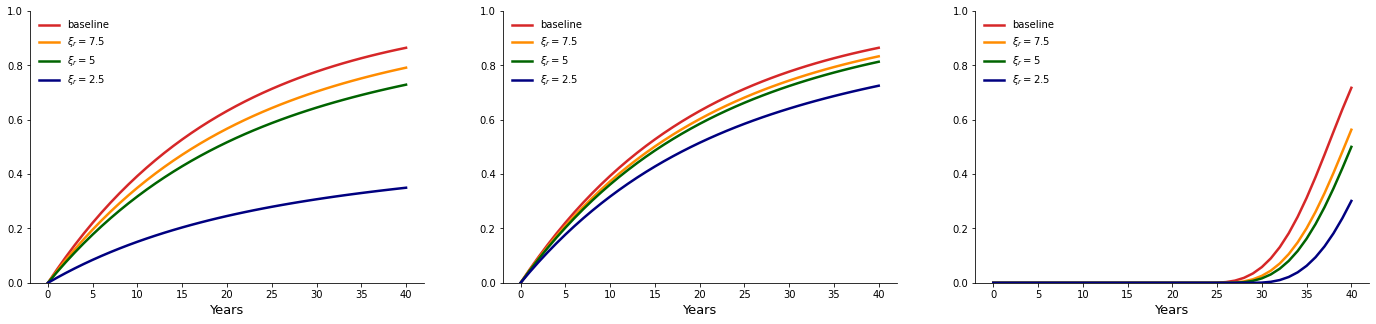

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 5))

ax1.plot(tech_prob_first[:41], label='baseline', linewidth=2.5, color='tab:red')
ax1.plot(distorted_tech_prob_first_7p5[:41], label=r'$\xi_r = 7.5$', linewidth=2.5, color='darkorange')
ax1.plot(distorted_tech_prob_first_5[:41], label=r'$\xi_r = 5$', linewidth=2.5, color='darkgreen')
ax1.plot(distorted_tech_prob_first_2p5[:41], label=r'$\xi_r = 2.5$', linewidth=2.5, color='navy')
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylim(0, 1)
ax1.legend()
# ax1.set_title(f'First technology jump', fontsize=13)

ax2.plot(tech_prob_second[:41], label='baseline', linewidth=2.5, color='tab:red')
ax2.plot(distorted_tech_prob_second_7p5[:41], label=r'$\xi_r = 7.5$', linewidth=2.5, color='darkorange')
ax2.plot(distorted_tech_prob_second_5[:41], label=r'$\xi_r = 5$', linewidth=2.5, color='darkgreen')
ax2.plot(distorted_tech_prob_second_2p5[:41], label=r'$\xi_r = 2.5$', linewidth=2.5, color='navy')
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylim(0, 1)
# ax2.set_title(f'Second technology jump', fontsize=13)
ax2.legend()

ax3.plot(dmg_prob[:41], label='baseline', linewidth=2.5, color='tab:red')
ax3.plot(distorted_dmg_prob_7p5[:41], label=r'$\xi_r = 7.5$', linewidth=2.5, color='darkorange')
ax3.plot(distorted_dmg_prob_5[:41], label=r'$\xi_r = 5$', linewidth=2.5, color='darkgreen')
ax3.plot(distorted_dmg_prob_2p5[:41], label=r'$\xi_r = 2.5$', linewidth=2.5, color='navy')
ax3.set_xlabel('Years', fontsize=13)
ax3.set_ylim(0, 1)
# ax3.set_title(f'Damage jump', fontsize=13)
ax3.legend(loc='upper left')

# fig.suptitle('Figure 5: Distorted probabilities', fontsize=13)
# fig.savefig(f'dice_prob.pdf', bbox_inches='tight')

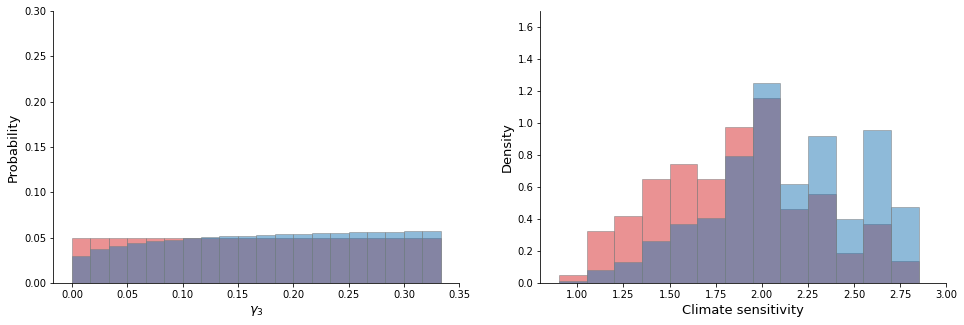

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(γ_3, weights=πd_o, alpha=0.5, color='tab:red', bins=20, label='baseline', edgecolor='grey')
ax1.hist(γ_3, weights=distorted_damage_probs[:, 40], alpha=0.5, bins=20, label='distorted', edgecolor='grey')
ax1.set_ylim(0, 0.3)
ax1.set_xlabel(r'$\gamma_3$', fontsize=13)
ax1.set_ylabel('Probability', fontsize=13)

bins = np.linspace(0., 3., 21)
ax2.hist(θ*1000, weights=πc_o, alpha=0.5, bins=bins, color='tab:red', label='baseline', edgecolor='grey', density=True)
ax2.hist(θ*1000, weights=πct[:, 40], bins=bins, alpha=0.5, label='distorted', edgecolor='grey', density=True)
ax2.set_xlim(.8, 3)
ax2.set_ylim(0, 1.7)
ax2.set_ylabel('Density', fontsize=13)
ax2.set_xlabel('Climate sensitivity', fontsize=13)

fig.savefig('distorted_histograms.pdf', bbox_inches='tight')